In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif
import warnings

In [2]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [3]:
# 1. Load and Combine Data
# -----------------------------
# Load order book data (depth20) and trade data (aggTrade)
depth20_files = [f"depth20_1000ms/BNBFDUSD_2025031{i}.txt" for i in range(4, 8)]
aggTrade_files = [f"aggTrade/BNBFDUSD_2025031{i}.txt" for i in range(4, 8)]

In [4]:
# Read and concatenate each set of files
depth_df = pd.concat([pd.read_csv(f, delimiter=",") for f in depth20_files], ignore_index=True)
agg_df = pd.concat([pd.read_csv(f, delimiter=",") for f in aggTrade_files], ignore_index=True)

In [5]:
# Standardize column names and clean timestamps
depth_df.rename(columns={depth_df.columns[0]: "Time_raw"}, inplace=True)
agg_df.rename(columns={agg_df.columns[0]: "Time_raw"}, inplace=True)

def clean_timestamp(ts):
    """Remove timezone information from timestamp strings"""
    return ts.split("+")[0].strip() if isinstance(ts, str) else ts

In [6]:
# Process timestamps for both datasets
for df in [depth_df, agg_df]:
    df["Time"] = pd.to_datetime(df["Time_raw"].apply(clean_timestamp), errors='coerce')
    df.dropna(subset=["Time"], inplace=True)
    df.sort_values("Time", inplace=True)

In [7]:
# Merge order book and trade data by nearest timestamp
merged_df = pd.merge_asof(depth_df, agg_df, on="Time", direction="nearest")
print(f"Merged dataset shape: {merged_df.shape}")

Merged dataset shape: (338519, 88)


In [8]:
merged_df.head(5)

,Time_raw_x,BidPriceL20,BidQtyL20,BidPriceL19,BidQtyL19,BidPriceL18,BidQtyL18,BidPriceL17,BidQtyL17,BidPriceL16,...,AskQtyL19,AskPriceL20,AskQtyL20,Time,Time_raw_y,Price,Quantity,IsMarketMaker,NumTrades,M
0,2025-03-14 00:00:02.292522546 +0530 IST,579.20,0.621,579.24,0.015,579.25,0.009,579.26,0.013,579.27,...,0.911,579.71,2.025,2025-03-14 00:00:02.292522546,2025-03-14 00:00:02.764823793 +0530 IST,579.41,0.496,True,1,True
1,2025-03-14 00:00:03.292828523 +0530 IST,579.08,2.612,579.09,8.606,579.10,3.453,579.11,3.825,579.12,...,1.017,579.63,0.048,2025-03-14 00:00:03.292828523,2025-03-14 00:00:02.8057318 +0530 IST,579.38,0.104,True,1,True
2,2025-03-14 00:00:04.292889586 +0530 IST,579.14,1.948,579.15,3.957,579.18,1.681,579.19,3.465,579.20,...,2.025,579.66,0.365,2025-03-14 00:00:04.292889586,2025-03-14 00:00:04.190545456 +0530 IST,579.40,1.726,False,1,True
3,2025-03-14 00:00:05.292551566 +0530 IST,579.07,0.013,579.08,0.013,579.09,8.606,579.10,3.453,579.11,...,0.279,579.60,7.213,2025-03-14 00:00:05.292551566,2025-03-14 00:00:05.3385294 +0530 IST,579.30,1.726,True,1,True
4,2025-03-14 00:00:06.292725093 +0530 IST,579.11,9.143,579.12,6.361,579.13,5.837,579.14,2.816,579.15,...,0.279,579.60,10.469,2025-03-14 00:00:06.292725093,2025-03-14 00:00:05.3385294 +0530 IST,579.30,1.726,True,1,True


In [10]:
# 2. Feature Engineering
features_df = merged_df.copy()


In [11]:
#2.1- Basic Liquidity & Depth Features
features_df['Bid_Ask_Spread'] = features_df['AskPriceL1'] - features_df['BidPriceL1']
features_df['Relative_Spread'] = features_df['Bid_Ask_Spread'] / ((features_df['AskPriceL1'] + features_df['BidPriceL1'])/2)
features_df['Mid_Price'] = (features_df['BidPriceL1'] + features_df['AskPriceL1']) / 2

In [12]:
# Calculate imbalance with zero-division protection
bid_ask_sum = features_df['BidQtyL1'] + features_df['AskQtyL1']
features_df['Imbalance_Lvl1'] = np.where(
    bid_ask_sum > 0,
    (features_df['BidQtyL1'] - features_df['AskQtyL1']) / bid_ask_sum,
    0
)

In [13]:
# Microprice calculation (price weighted by opposite side quantity)
features_df['Microprice'] = np.where(
    bid_ask_sum > 0,
    (features_df['BidPriceL1'] * features_df['AskQtyL1'] + features_df['AskPriceL1'] * features_df['BidQtyL1']) / bid_ask_sum,
    features_df['Mid_Price']  # Default to mid price when quantities are zero
)

In [15]:
# 2.2 Order Book Depth Features
# Prepare column names for different order book levels
bid_qty_cols = [f'BidQtyL{i}' for i in range(1, 21)]
ask_qty_cols = [f'AskQtyL{i}' for i in range(1, 21)]
bid_price_cols = [f'BidPriceL{i}' for i in range(1, 21)]
ask_price_cols = [f'AskPriceL{i}' for i in range(1, 21)]

In [16]:
# Calculate cumulative quantities at different depth levels
features_df['Cum_Bid_Qty'] = features_df[bid_qty_cols].sum(axis=1)
features_df['Cum_Ask_Qty'] = features_df[ask_qty_cols].sum(axis=1)
features_df['Cum_Bid_Qty_L5'] = features_df[[f'BidQtyL{i}' for i in range(1, 6)]].sum(axis=1)
features_df['Cum_Ask_Qty_L5'] = features_df[[f'AskQtyL{i}' for i in range(1, 6)]].sum(axis=1)
features_df['Cum_Bid_Qty_L10'] = features_df[[f'BidQtyL{i}' for i in range(1, 11)]].sum(axis=1)
features_df['Cum_Ask_Qty_L10'] = features_df[[f'AskQtyL{i}' for i in range(1, 11)]].sum(axis=1)

In [17]:
# 2.3 Order Book Imbalance Features
def safe_imbalance(bid_qty, ask_qty):
    """Calculate imbalance with protection against division by zero"""
    total = bid_qty + ask_qty
    return np.where(total > 0, (bid_qty - ask_qty) / total, 0)

features_df['Imbalance_Total'] = safe_imbalance(features_df['Cum_Bid_Qty'], features_df['Cum_Ask_Qty'])
features_df['Imbalance_L5'] = safe_imbalance(features_df['Cum_Bid_Qty_L5'], features_df['Cum_Ask_Qty_L5'])
features_df['Imbalance_L10'] = safe_imbalance(features_df['Cum_Bid_Qty_L10'], features_df['Cum_Ask_Qty_L10'])

In [18]:
# 2.4 Order Book Slope Features
def weighted_depth_distance(row, price_cols, qty_cols, mid_price, side='bid'):
    """Calculate weighted average distance of volume from mid price"""
    total_qty = sum(row[qty_cols])
    if total_qty == 0:
        return 0

    if side == 'bid':
        distances = [(mid_price - row[price]) * row[qty] for price, qty in zip(price_cols, qty_cols)]
    else:  # ask side
        distances = [(row[price] - mid_price) * row[qty] for price, qty in zip(price_cols, qty_cols)]

    return sum(distances) / total_qty

In [20]:
# Calculate bid and ask slopes (measure of liquidity distribution)
features_df['Bid_Slope'] = features_df.apply(
    lambda row: weighted_depth_distance(row, bid_price_cols, bid_qty_cols, row['Mid_Price'], 'bid'),
    axis=1
)
features_df['Ask_Slope'] = features_df.apply(
    lambda row: weighted_depth_distance(row, ask_price_cols, ask_qty_cols, row['Mid_Price'], 'ask'),
    axis=1
)

In [ ]:
# # Calculate slope ratio with protection
# features_df['Slope_Ratio'] = np.where(
#     features_df['Ask_Slope'] != 0,
#     features_df['Bid_Slope'] / features_df['Ask_Slope'],
#     features_df['Bid_Slope']
# )

In [23]:
# 2.5 Price Action and Volatility Features
features_df['Log_Return'] = np.log(features_df['Mid_Price'] / features_df['Mid_Price'].shift(1))
features_df['Abs_Return'] = np.abs(features_df['Log_Return'])
features_df['Volatility_10s'] = features_df['Log_Return'].rolling(window=10, min_periods=1).std()
features_df['Volatility_30s'] = features_df['Log_Return'].rolling(window=30, min_periods=1).std()
features_df['Volatility_60s'] = features_df['Log_Return'].rolling(window=60, min_periods=1).std()

In [26]:
# 2.6 Trend/Mean-Reversion Indicators
def safe_rsi(series, window=10):
    """Calculate RSI with protection against division by zero"""
    delta = series.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    down = -down  # Convert to positive values
    
    roll_up = up.rolling(window, min_periods=1).mean()
    roll_down = down.rolling(window, min_periods=1).mean()
    
    # Avoid division by zero
    rs = np.where(roll_down != 0, roll_up / roll_down, 1)
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

features_df['RSI_10'] = safe_rsi(features_df['Log_Return'], 10)

In [24]:
# Moving averages for trend detection
features_df['SMA_10'] = features_df['Mid_Price'].rolling(window=10, min_periods=1).mean()
features_df['SMA_30'] = features_df['Mid_Price'].rolling(window=30, min_periods=1).mean()
features_df['Price_Trend_Indicator'] = np.where(
    features_df['SMA_30'] != 0,
    features_df['SMA_10'] / features_df['SMA_30'] - 1,
    0
)

In [28]:
# Autocorrelation (mean-reversion vs trending indicator)
def safe_autocorr(series, lag=5):
    """Calculate autocorrelation with protection against edge cases"""
    if len(series) <= lag:
        return 0
    
    mean = series.mean()
    if series.std() == 0:
        return 0
    
    autocorr = ((series[lag:] - mean) * (series[:-lag] - mean)).sum() / \
               ((series - mean) ** 2).sum()
    return autocorr

features_df['Autocorrelation_5'] = features_df['Log_Return'].rolling(window=10, min_periods=5).apply(
    lambda x: safe_autocorr(pd.Series(x), lag=5), raw=False
)

In [ ]:
# 2.7 Volume Features
features_df['Volume_Imbalance'] = np.where(features_df['IsMarketMaker'], 
                                          features_df['Quantity'], 
                                          -features_df['Quantity'])
features_df['Cumulative_Volume_10s'] = features_df['Quantity'].rolling(window=10, min_periods=1).sum()
features_df['Cumulative_Volume_30s'] = features_df['Quantity'].rolling(window=30, min_periods=1).sum()
features_df['Cumulative_Volume_60s'] = features_df['Quantity'].rolling(window=60, min_periods=1).sum()

In [ ]:
# 2.8 VWAP Features
qty_cumsum = features_df['Quantity'].cumsum()
price_qty_cumsum = (features_df['Price'] * features_df['Quantity']).cumsum()
features_df['VWAP'] = np.where(
    qty_cumsum > 0,
    price_qty_cumsum / qty_cumsum,
    features_df['Mid_Price']
)
features_df['VWAP_Shift_10s'] = features_df['VWAP'].diff(10)
features_df['VWAP_Shift_30s'] = features_df['VWAP'].diff(30)
features_df['Price_VWAP_Gap'] = features_df['Mid_Price'] - features_df['VWAP']

In [ ]:
# 2.9 Additional Derived Features
# Sloped depth - how quickly liquidity decays from top of book
bid_qty_rest_sum = features_df[[f'BidQtyL{i}' for i in range(2, 21)]].sum(axis=1)
features_df['Sloped_Depth'] = np.where(
    bid_qty_rest_sum > 0,
    features_df['BidQtyL1'] / bid_qty_rest_sum,
    features_df['BidQtyL1']
)

In [ ]:
# Liquidity ratio between bid and ask sides
features_df['Liquidity_Ratio'] = np.where(
    features_df['Cum_Ask_Qty_L5'] > 0,
    features_df['Cum_Bid_Qty_L5'] / features_df['Cum_Ask_Qty_L5'],
    features_df['Cum_Bid_Qty_L5']
)

In [ ]:
# Trade wipe levels - measure of market impact
def count_wipes(df, cols, window, threshold=-0.9):
    """Count significant drops in quantity (potential trade wipes)"""
    pct_change = df[cols].pct_change(periods=window)
    return (pct_change < threshold).sum(axis=1)

features_df['Trade_Wipe_Lvl_10s'] = count_wipes(features_df, bid_qty_cols, 10)
features_df['Trade_Wipe_Lvl_30s'] = count_wipes(features_df, bid_qty_cols, 30)

In [ ]:
# Compile list of engineered features for clustering
selected_feature_cols = [
    'Bid_Ask_Spread', 'Relative_Spread', 'Imbalance_Lvl1', 'Microprice',
    'Cum_Bid_Qty', 'Cum_Ask_Qty', 'Imbalance_Total', 'Imbalance_L5',
    'Bid_Slope', 'Ask_Slope', 'Slope_Ratio',
    'Log_Return', 'Abs_Return', 'Volatility_10s', 'Volatility_30s', 'Volatility_60s',
    'RSI_10', 'Price_Trend_Indicator', 'Autocorrelation_5',
    'Volume_Imbalance', 'Cumulative_Volume_10s', 'Cumulative_Volume_30s',
    'VWAP_Shift_10s', 'VWAP_Shift_30s', 'Price_VWAP_Gap',
    'Sloped_Depth', 'Liquidity_Ratio', 'Trade_Wipe_Lvl_10s', 'Trade_Wipe_Lvl_30s'
]

print(f"Total engineered features: {len(selected_feature_cols)}")

In [ ]:
nan_counts = features_df[selected_feature_cols].isna().sum()
print("\nNaN counts per feature:")
print(nan_counts)


In [ ]:
# Impute missing values based on feature type
for col in selected_feature_cols:
    if features_df[col].isna().any():
        if col in ['Log_Return', 'Volatility_10s', 'Volatility_30s', 'Volatility_60s', 'RSI_10', 'Autocorrelation_5']:
            # For returns and volatility, fill with 0 (neutral value)
            features_df[col] = features_df[col].fillna(0)
        elif 'Shift' in col or 'diff' in col:
            # For shift/difference features, fill with 0 (no change)
            features_df[col] = features_df[col].fillna(0)
        else:
            # For other features, use median (robust central tendency)
            features_df[col] = features_df[col].fillna(features_df[col].median())

In [ ]:
# Prepare data for clustering
clustering_data = features_df[selected_feature_cols]
print(f"Clustering data shape: {clustering_data.shape}")

In [ ]:
# Apply standardization (z-score normalization)
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)
clustering_data_scaled_df = pd.DataFrame(
    clustering_data_scaled, 
    columns=selected_feature_cols, 
    index=clustering_data.index
)

In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(random_state=42)
pca_data = pca.fit_transform(clustering_data_scaled)

In [ ]:
# Plot explained variance to determine optimal number of components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Threshold')
plt.grid(True)
plt.title('PCA Explained Variance')
plt.legend()
plt.show()

In [ ]:
# Select components explaining 90% of variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
print(f"Number of PCA components explaining 90% variance: {n_components}")

In [ ]:
# Apply PCA with selected number of components
pca = PCA(n_components=n_components, random_state=42)
clustering_data_pca = pca.fit_transform(clustering_data_scaled)

In [53]:
sse = []
silhouette_scores = []
db_scores = []
ch_scores = []
k_range = range(2, 11)

In [54]:
# Sample size for silhouette score optimization (prevents slow computation on large datasets)
sample_size = min(10000, clustering_data_scaled.shape[0])

for k in k_range:
    # Fit KMeans
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(clustering_data_scaled)
    
    # Get labels
    labels = km.labels_
    
    # Calculate metrics
    sse.append(km.inertia_)
    silhouette_scores.append(silhouette_score(clustering_data_scaled, labels, sample_size=sample_size, random_state=42))
    db_scores.append(davies_bouldin_score(clustering_data_scaled, labels))
    ch_scores.append(calinski_harabasz_score(clustering_data_scaled, labels))

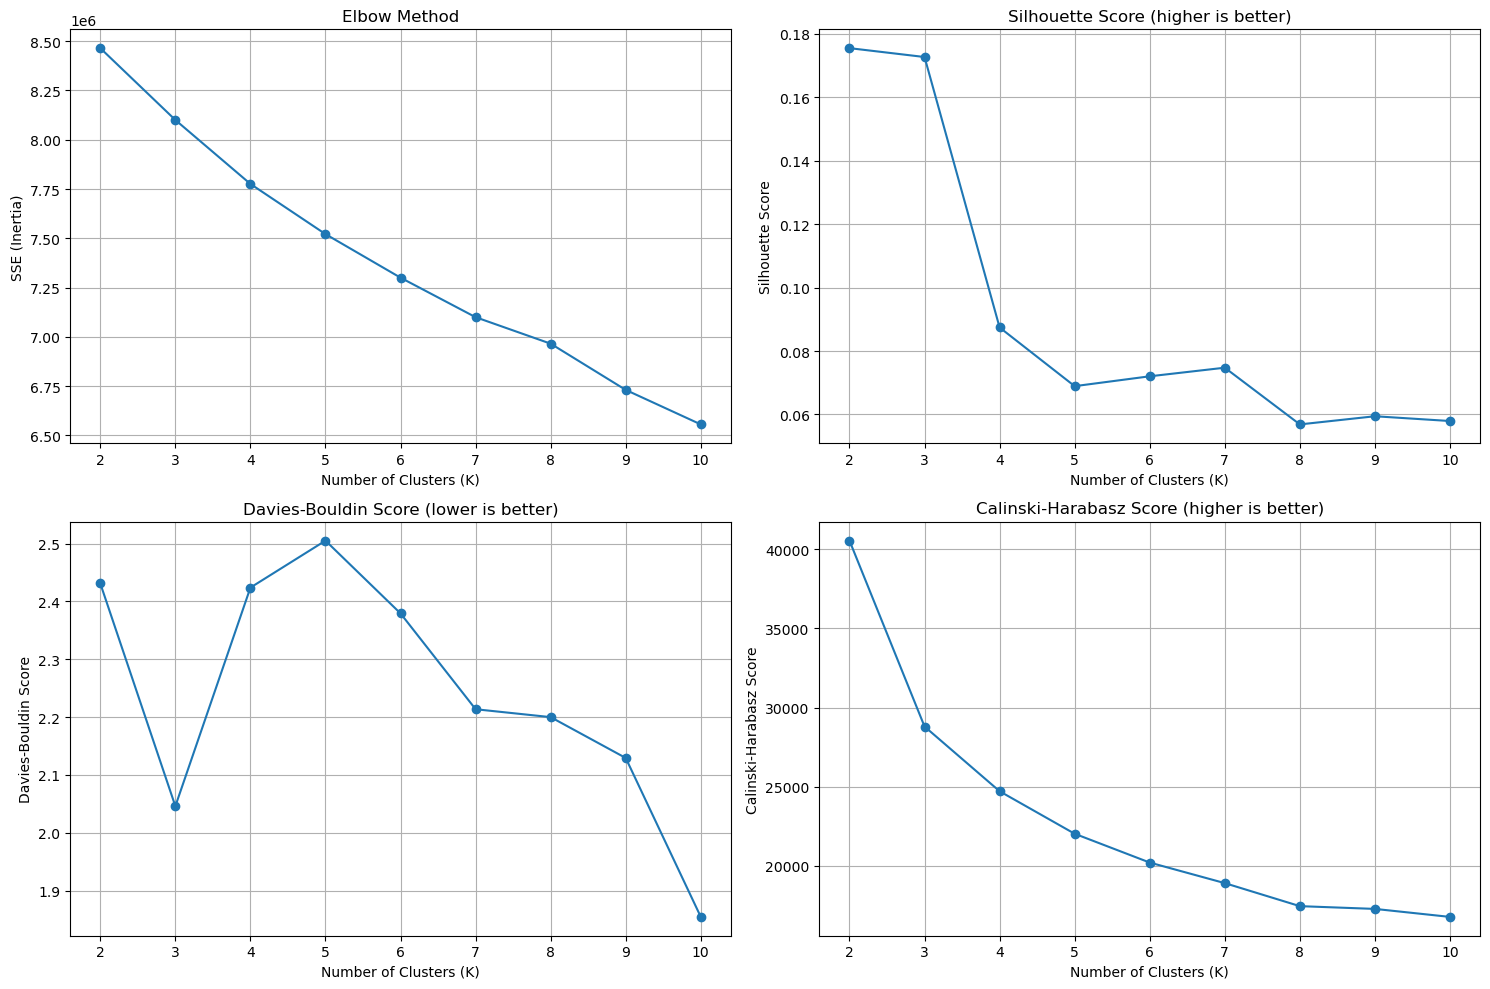

In [60]:
# Plot metrics for optimal K selection
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# Elbow Method - SSE (lower is better, look for "elbow")
axs[0, 0].plot(k_range, sse, marker='o')
axs[0, 0].set_xlabel('Number of Clusters (K)')
axs[0, 0].set_ylabel('SSE (Inertia)')
axs[0, 0].set_title('Elbow Method')
axs[0, 0].grid(True)
# Silhouette Score (higher is better)
axs[0, 1].plot(k_range, silhouette_scores, marker='o')
axs[0, 1].set_xlabel('Number of Clusters (K)')
axs[0, 1].set_ylabel('Silhouette Score')
axs[0, 1].set_title('Silhouette Score (higher is better)')
axs[0, 1].grid(True)
# Davies-Bouldin Score (lower is better)
axs[1, 0].plot(k_range, db_scores, marker='o')
axs[1, 0].set_xlabel('Number of Clusters (K)')
axs[1, 0].set_ylabel('Davies-Bouldin Score')
axs[1, 0].set_title('Davies-Bouldin Score (lower is better)')
axs[1, 0].grid(True)
# Calinski-Harabasz Score (higher is better)
axs[1, 1].plot(k_range, ch_scores, marker='o')
axs[1, 1].set_xlabel('Number of Clusters (K)')
axs[1, 1].set_ylabel('Calinski-Harabasz Score')
axs[1, 1].set_title('Calinski-Harabasz Score (higher is better)')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [61]:
# Select optimal k based on metrics
optimal_k = 4  # Change this based on the plot results if needed
print(f"Selected optimal number of clusters (K): {optimal_k}")

Selected optimal number of clusters (K): 4


In [62]:
# 4.2 Apply All Clustering Algorithms
# KMeans with optimal K
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(clustering_data_scaled)
features_df.loc[clustering_data.index, 'KMeans_Labels'] = kmeans_labels

In [63]:
# HDBSCAN on PCA-reduced data
hdb = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=5)
hdbscan_labels = hdb.fit_predict(clustering_data_pca)
features_df.loc[clustering_data.index, 'HDBSCAN_Labels'] = hdbscan_labels

In [64]:
# Gaussian Mixture Model
gmm = GaussianMixture(n_components=optimal_k, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(clustering_data_scaled)
features_df.loc[clustering_data.index, 'GMM_Labels'] = gmm_labels
features_df.loc[clustering_data.index, 'GMM_Prob_Max'] = gmm.predict_proba(clustering_data_scaled).max(axis=1)

In [65]:
# 4.3 Compare Clustering Quality
def evaluate_clustering(data, labels, name):
    """Calculate clustering quality metrics for a given set of labels"""
    unique_labels = np.unique(labels)
    # Only evaluate if there are at least 2 clusters and no noise marker (-1)
    if len(unique_labels) > 1 and -1 not in unique_labels:
        # Use sampling for silhouette score to improve performance
        sample_size = min(10000, data.shape[0])
        sil = silhouette_score(data, labels, sample_size=sample_size, random_state=42)
        dbi = davies_bouldin_score(data, labels)
        chi = calinski_harabasz_score(data, labels)
        return f"{name} -> Silhouette: {sil:.4f}, Davies-Bouldin: {dbi:.4f}, Calinski-Harabasz: {chi:.4f}"
    else:
        # For HDBSCAN with noise points
        if -1 in unique_labels and len(unique_labels) > 2:
            non_noise_mask = labels != -1
            if sum(non_noise_mask) > 1:
                sample_size = min(10000, sum(non_noise_mask))
                sil = silhouette_score(data[non_noise_mask], labels[non_noise_mask], 
                                     sample_size=sample_size, random_state=42)
                dbi = davies_bouldin_score(data[non_noise_mask], labels[non_noise_mask])
                chi = calinski_harabasz_score(data[non_noise_mask], labels[non_noise_mask])
                return f"{name} (excluding noise) -> Silhouette: {sil:.4f}, Davies-Bouldin: {dbi:.4f}, Calinski-Harabasz: {chi:.4f}"
        return f"{name} -> Not evaluable (only 1 cluster or includes noise)"

In [66]:
# Compare all clustering methods
results = {
    'KMeans': evaluate_clustering(clustering_data_scaled, kmeans_labels, 'KMeans'),
    'HDBSCAN': evaluate_clustering(clustering_data_pca, hdbscan_labels, 'HDBSCAN'),
    'GMM': evaluate_clustering(clustering_data_scaled, gmm_labels, 'GMM')
}

In [67]:
print("\nClustering Quality Comparison:")
for model, res in results.items():
    print(res)


Clustering Quality Comparison:
KMeans -> Silhouette: 0.0874, Davies-Bouldin: 2.4238, Calinski-Harabasz: 24710.7342
HDBSCAN (excluding noise) -> Silhouette: 0.3604, Davies-Bouldin: 1.1293, Calinski-Harabasz: 1315.6134
GMM -> Silhouette: 0.0389, Davies-Bouldin: 4.0663, Calinski-Harabasz: 10909.5087


In [68]:
# Select the best clustering method based on metrics
selected_clustering = 'KMeans_Labels'  # Update this if another method performs better
print(f"\nSelected clustering method: {selected_clustering}")


Selected clustering method: KMeans_Labels


In [69]:
def characterize_regimes(df, labels_col):
    """Systematically characterize market regimes based on the three key factors"""
    regimes = pd.DataFrame(index=np.unique(df[labels_col].dropna()))

    # 1. Trending vs Mean-Reverting
    trend_metrics = {
        'Autocorrelation_5': 'mean',  # Higher values indicate trending behavior
        'Price_Trend_Indicator': 'mean',  # Higher absolute values indicate stronger trends
        'RSI_10': 'mean'  # Extreme values (near 0 or 100) indicate trend
    }

    trend_stats = df.groupby(labels_col)[list(trend_metrics.keys())].agg(trend_metrics)
    # Compute a trend score: higher = more trending, lower = more mean-reverting
    regimes['Trend_Score'] = trend_stats['Autocorrelation_5'] + trend_stats['Price_Trend_Indicator'].abs()
    regimes['Trend_Type'] = np.where(regimes['Trend_Score'] > regimes['Trend_Score'].median(), 'Trending', 'Mean-Reverting')

    # 2. Volatile vs Stable
    volatility_metrics = {
        'Volatility_10s': 'mean',
        'Volatility_30s': 'mean',
        'Abs_Return': 'mean'
    }

    vol_stats = df.groupby(labels_col)[list(volatility_metrics.keys())].agg(volatility_metrics)
    # Normalize and combine for a volatility score
    regimes['Volatility_Score'] = vol_stats['Volatility_10s'] + vol_stats['Volatility_30s']
    regimes['Volatility_Type'] = np.where(regimes['Volatility_Score'] > regimes['Volatility_Score'].median(), 'Volatile', 'Stable')

    # 3. Liquid vs Illiquid
    liquidity_metrics = {
        'Bid_Ask_Spread': 'mean',
        'Cum_Bid_Qty_L5': 'mean',
        'Cum_Ask_Qty_L5': 'mean',
        'Sloped_Depth': 'mean'
    }

    liq_stats = df.groupby(labels_col)[list(liquidity_metrics.keys())].agg(liquidity_metrics)
    # For liquidity score: higher spread = less liquid, higher depth = more liquid
    regimes['Liquidity_Score'] = (liq_stats['Cum_Bid_Qty_L5'] + liq_stats['Cum_Ask_Qty_L5']) / liq_stats['Bid_Ask_Spread']
    regimes['Liquidity_Type'] = np.where(regimes['Liquidity_Score'] > regimes['Liquidity_Score'].median(), 'Liquid', 'Illiquid')

    # Create combined regime names based on the three factors
    regimes['Regime_Name'] = regimes['Trend_Type'] + ' & ' + regimes['Liquidity_Type'] + ' & ' + regimes['Volatility_Type']

    # Add additional statistics for deeper insights
    for feature in ['Bid_Ask_Spread', 'Volatility_30s', 'Cumulative_Volume_30s', 'Imbalance_Total']:
        regimes[feature] = df.groupby(labels_col)[feature].mean()

    return regimes

In [70]:
# Characterize regimes for the selected clustering method
regime_characteristics = characterize_regimes(features_df.dropna(subset=[selected_clustering]), selected_clustering)
print("\n🔍 Regime Characteristics:")
print(regime_characteristics)


🔍 Regime Characteristics:
      Trend_Score      Trend_Type  Volatility_Score Volatility_Type  \
0.0  5.157139e-06        Trending          0.000121          Stable   
1.0  1.635559e-06  Mean-Reverting          0.000295        Volatile   
2.0  3.602572e-07  Mean-Reverting          0.000133          Stable   
3.0  1.208765e-05        Trending          0.000152        Volatile   

     Liquidity_Score Liquidity_Type                           Regime_Name  \
0.0       275.790748         Liquid            Trending & Liquid & Stable   
1.0       143.389678       Illiquid  Mean-Reverting & Illiquid & Volatile   
2.0       165.354042       Illiquid    Mean-Reverting & Illiquid & Stable   
3.0      3748.627363         Liquid          Trending & Liquid & Volatile   

     Bid_Ask_Spread  Volatility_30s  Cumulative_Volume_30s  Imbalance_Total  
0.0        0.051581        0.000063              20.787086        -0.008810  
1.0        0.102246        0.000148              26.009942        -0.026072

In [71]:
# Map regime names back to the main dataframe
regime_names_map = regime_characteristics['Regime_Name'].to_dict()
features_df['Regime_Name'] = features_df[selected_clustering].map(regime_names_map)

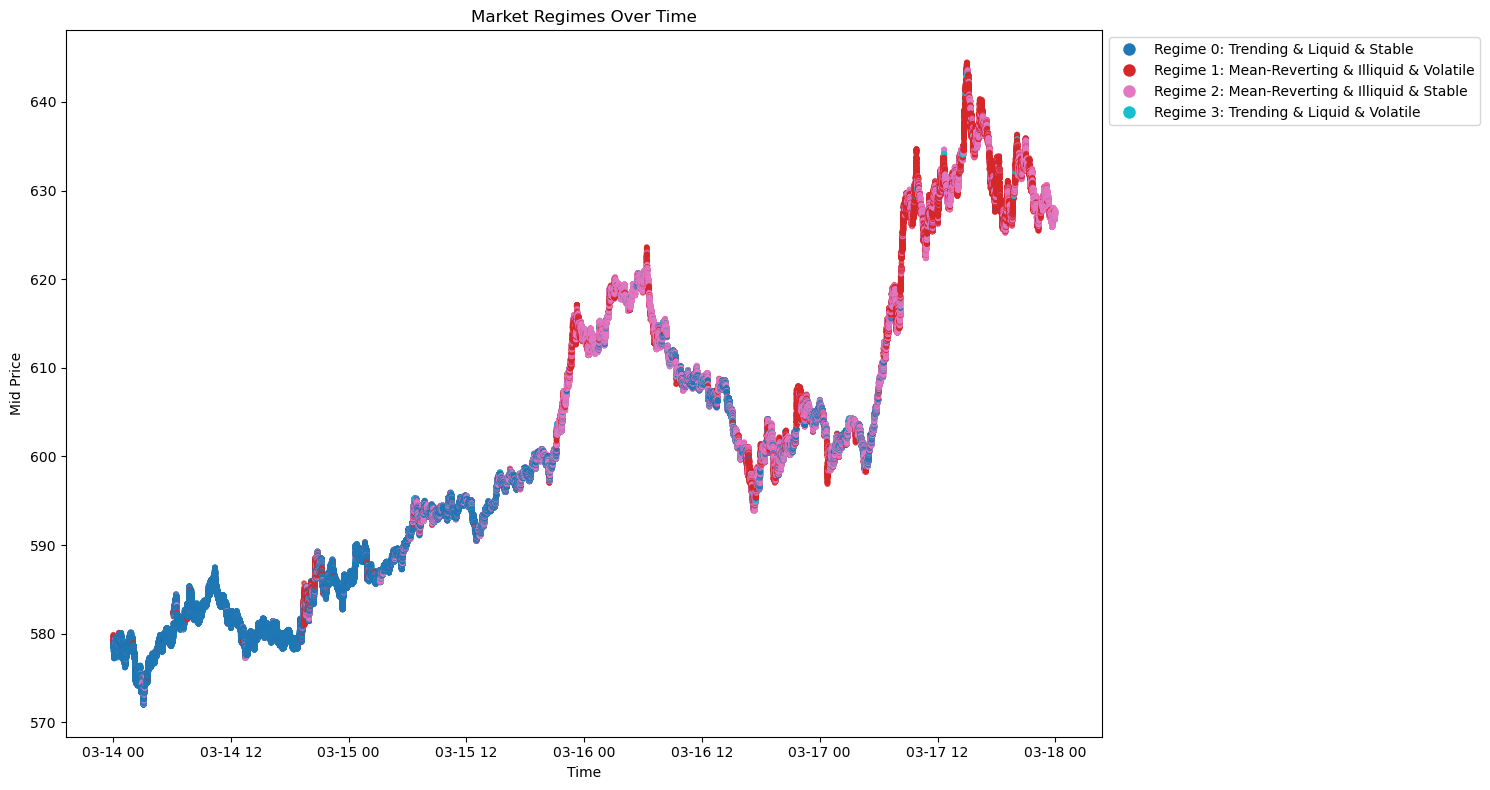

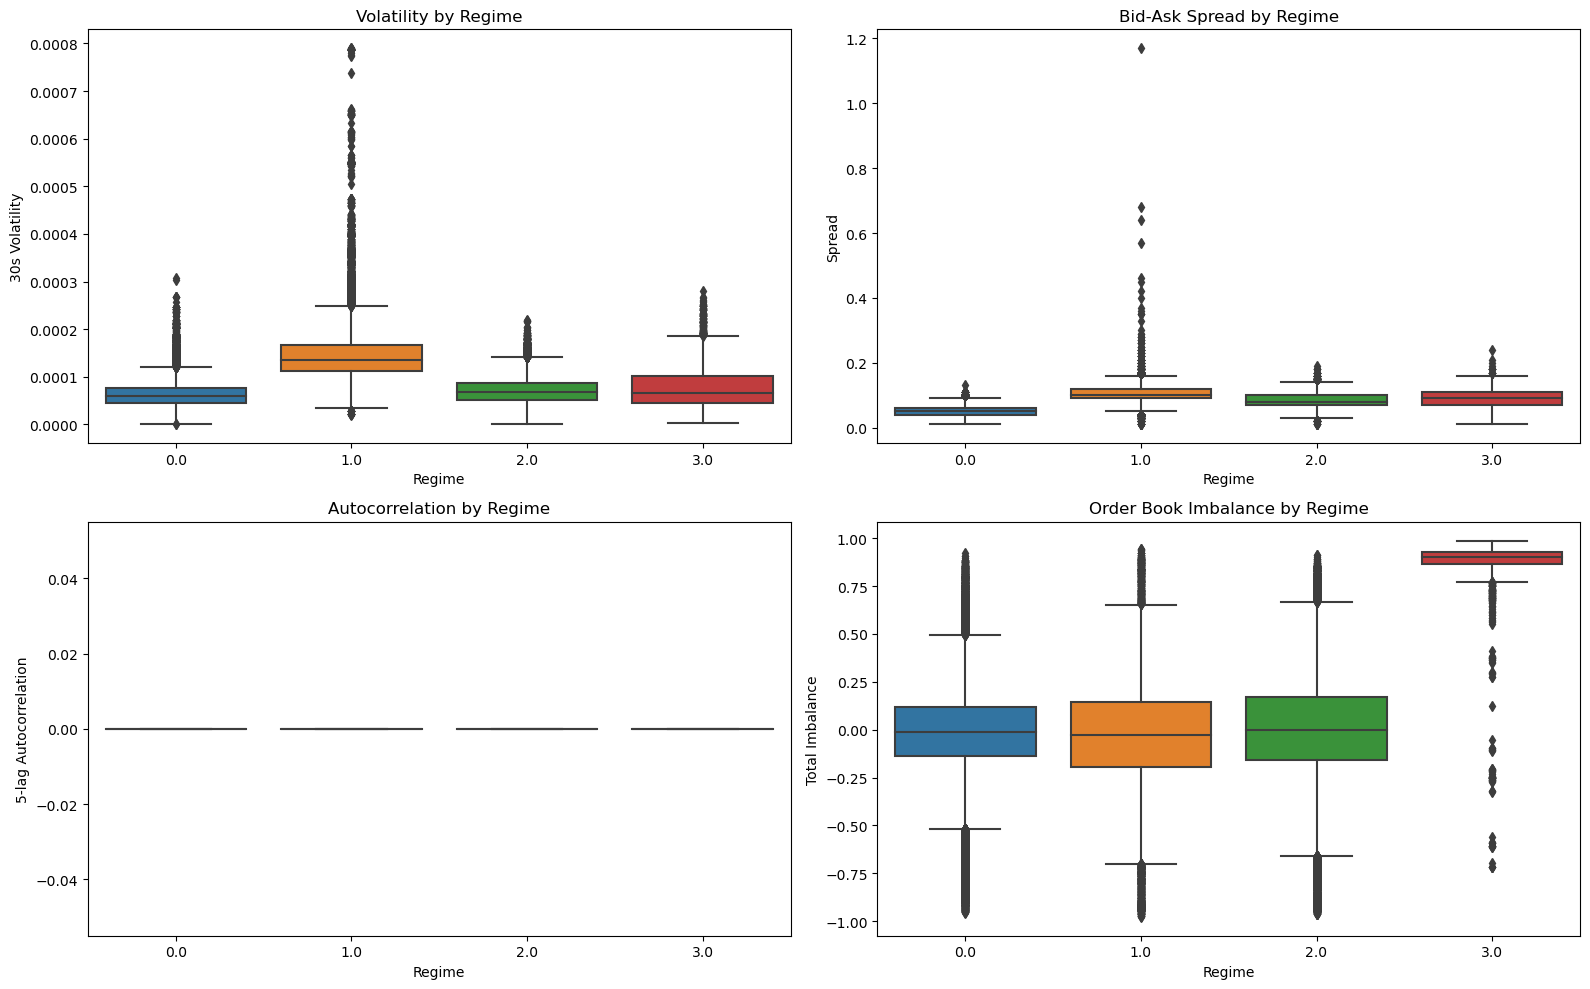

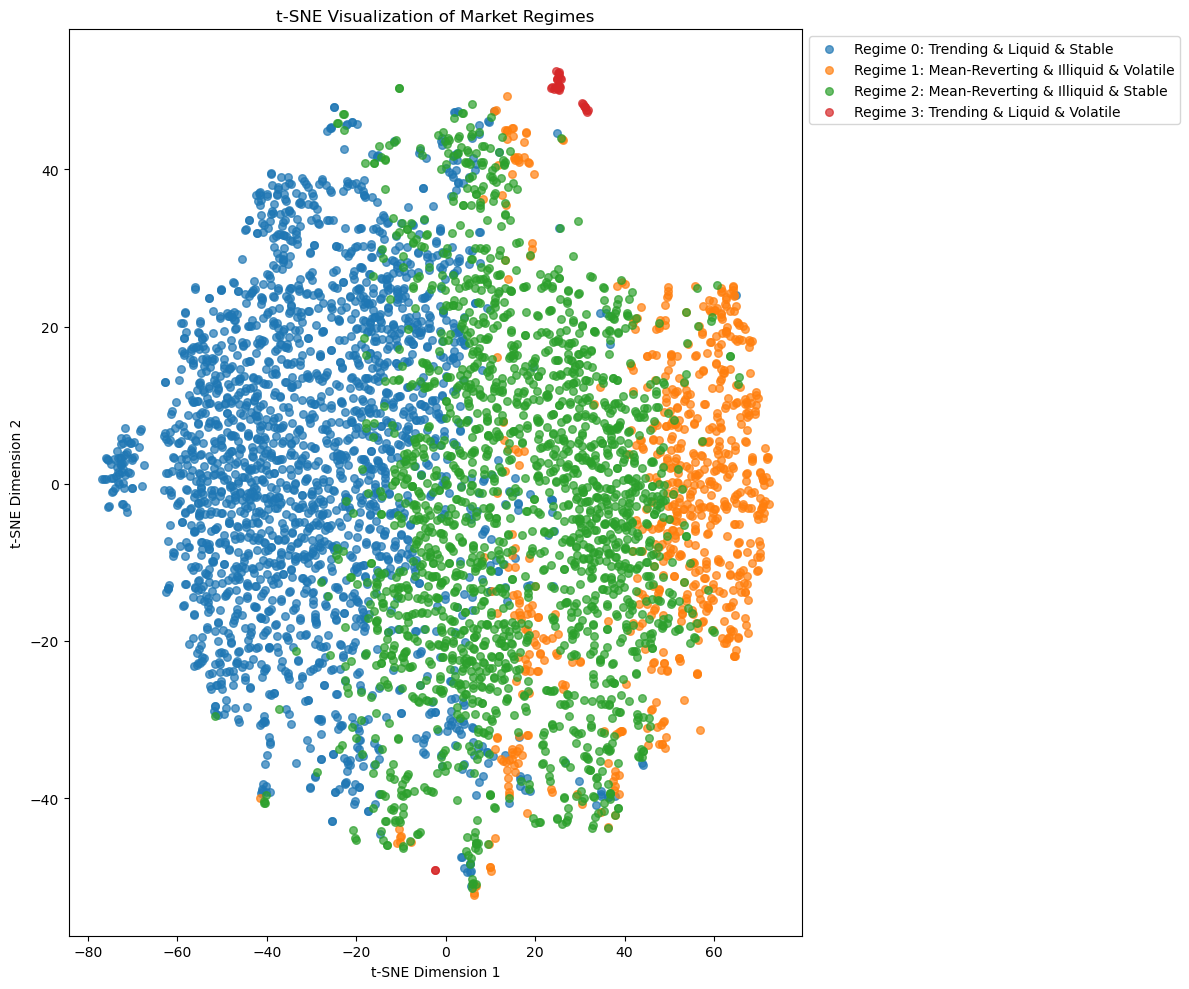

In [77]:
plt.figure(figsize=(15, 8))
scatter = plt.scatter(features_df['Time'], features_df['Mid_Price'],
                     c=features_df[selected_clustering], cmap='tab10', s=10, alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Mid Price')
plt.title('Market Regimes Over Time')
# Add legend with regime names
legend_elements = []
for cluster_id, regime_name in regime_names_map.items():
    if not np.isnan(cluster_id):  # Skip NaN entries
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                         markerfacecolor=scatter.cmap(scatter.norm(cluster_id)),
                                         markersize=10, label=f"Regime {int(cluster_id)}: {regime_name}"))
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
# 6.2 Feature distributions by regime
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Volatility by regime (for Volatile vs Stable)
sns.boxplot(x=features_df[selected_clustering], y=features_df['Volatility_30s'], ax=axs[0, 0])
axs[0, 0].set_title('Volatility by Regime')
axs[0, 0].set_xlabel('Regime')
axs[0, 0].set_ylabel('30s Volatility')

# Bid-Ask Spread by regime (for Liquid vs Illiquid)
sns.boxplot(x=features_df[selected_clustering], y=features_df['Bid_Ask_Spread'], ax=axs[0, 1])
axs[0, 1].set_title('Bid-Ask Spread by Regime')
axs[0, 1].set_xlabel('Regime')
axs[0, 1].set_ylabel('Spread')

# Autocorrelation by regime (for Trending vs Mean-Reverting)
sns.boxplot(x=features_df[selected_clustering], y=features_df['Autocorrelation_5'], ax=axs[1, 0])
axs[1, 0].set_title('Autocorrelation by Regime')
axs[1, 0].set_xlabel('Regime')
axs[1, 0].set_ylabel('5-lag Autocorrelation')

# Order Book Imbalance by regime
sns.boxplot(x=features_df[selected_clustering], y=features_df['Imbalance_Total'], ax=axs[1, 1])
axs[1, 1].set_title('Order Book Imbalance by Regime')
axs[1, 1].set_xlabel('Regime')
axs[1, 1].set_ylabel('Total Imbalance')

plt.tight_layout()
plt.show()
# 6.3 t-SNE visualization of clusters
# Use smaller sample for t-SNE to improve performance
tsne_sample_size = min(5000, len(clustering_data_scaled))
tsne_indices = np.random.choice(len(clustering_data_scaled), tsne_sample_size, replace=False)
tsne_data_sample = clustering_data_scaled[tsne_indices]
tsne_labels_sample = kmeans_labels[tsne_indices]

# Compute t-SNE with optimized parameters
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, tsne_sample_size//10))
tsne_result = tsne.fit_transform(tsne_data_sample)

# Create DataFrame for plotting
tsne_df = pd.DataFrame({
    'TSNE1': tsne_result[:, 0],
    'TSNE2': tsne_result[:, 1],
    'Cluster': tsne_labels_sample
})
tsne_df['Regime_Name'] = tsne_df['Cluster'].map(regime_names_map)

# Plot t-SNE visualization
plt.figure(figsize=(12, 10))
for cluster_id, regime_name in regime_names_map.items():
    if not np.isnan(cluster_id):
        cluster_data = tsne_df[tsne_df['Cluster'] == cluster_id]
        plt.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'],
                  label=f"Regime {int(cluster_id)}: {regime_name}", s=30, alpha=0.7)

plt.title('t-SNE Visualization of Market Regimes')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [78]:
# 7.1 Transition Probabilities
features_df_sorted = features_df.dropna(subset=[selected_clustering]).sort_values('Time')
features_df_sorted['Next_Regime'] = features_df_sorted[selected_clustering].shift(-1)

In [79]:
# Compute transition matrix
transition_counts = pd.crosstab(features_df_sorted[selected_clustering], features_df_sorted['Next_Regime'])
transition_probabilities = transition_counts.div(transition_counts.sum(axis=1), axis=0)

In [80]:
print("\n Regime Transition Probabilities:")
print(transition_probabilities)


 Regime Transition Probabilities:
Next_Regime         0.0       1.0       2.0       3.0
KMeans_Labels                                        
0.0            0.884235  0.008986  0.106598  0.000181
1.0            0.024363  0.803324  0.170539  0.001774
2.0            0.124936  0.059317  0.815067  0.000680
3.0            0.014194  0.044872  0.034341  0.906593


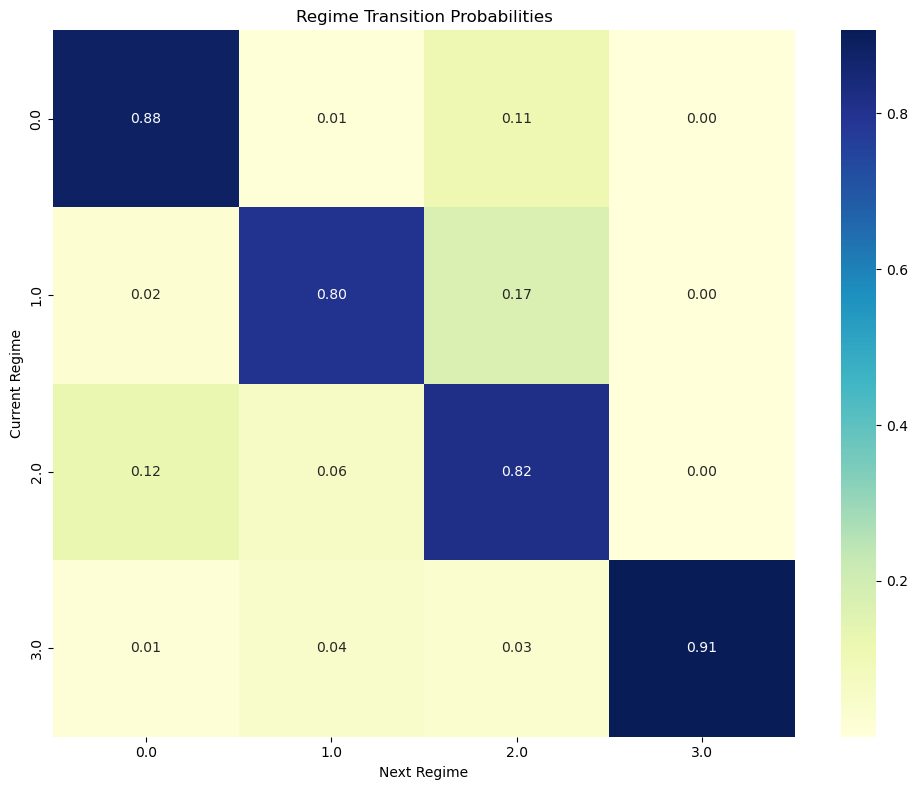

In [81]:
# Visualize as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(transition_probabilities, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Regime Transition Probabilities')
plt.xlabel('Next Regime')
plt.ylabel('Current Regime')
plt.tight_layout()
plt.show()

In [82]:
# 7.2 Regime Duration Analysis
regime_changes = features_df_sorted[selected_clustering].diff() != 0
regime_start_indices = features_df_sorted[regime_changes].index

In [83]:
# Correctly combine indices (first index + change indices)
first_idx = pd.Index([features_df_sorted.index[0]])
regime_start_indices = pd.Index(list(first_idx) + list(regime_start_indices))

regime_durations = []
for i in range(len(regime_start_indices) - 1):
    start_idx = regime_start_indices[i]
    end_idx = regime_start_indices[i + 1]
    regime = features_df_sorted.loc[start_idx, selected_clustering]
    regime_name = features_df_sorted.loc[start_idx, 'Regime_Name']
    duration = (features_df_sorted.loc[end_idx, 'Time'] - features_df_sorted.loc[start_idx, 'Time']).total_seconds()
    regime_durations.append({
        'Regime': regime,
        'Regime_Name': regime_name,
        'Start_Time': features_df_sorted.loc[start_idx, 'Time'],
        'End_Time': features_df_sorted.loc[end_idx, 'Time'],
        'Duration_Seconds': duration
    })

regime_durations_df = pd.DataFrame(regime_durations)

In [84]:
# Calculate average duration by regime
avg_durations = regime_durations_df.groupby('Regime')['Duration_Seconds'].agg(['mean', 'min', 'max', 'count'])
avg_durations['mean_minutes'] = avg_durations['mean'] / 60

print("\n Average Regime Durations:")
print(avg_durations)


 Average Regime Durations:
             mean       min          max  count  mean_minutes
Regime                                                       
0.0      8.830676  0.000000  2212.000043  17909      0.147178
1.0      5.091252  0.785121   411.000048   9421      0.084854
2.0      5.546461  0.931603   333.000067  24733      0.092441
3.0     10.833742  0.971406   196.999995    204      0.180562


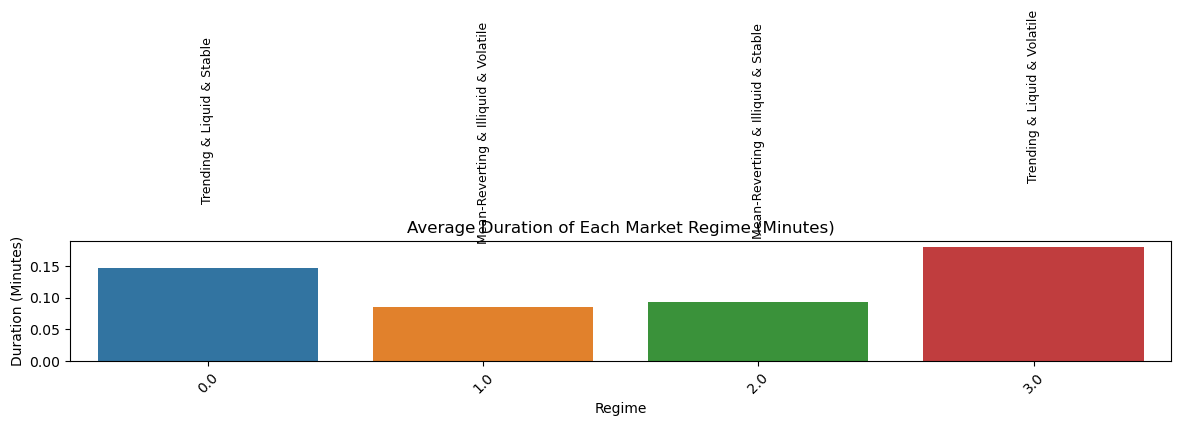

In [85]:
# Plot average durations
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_durations.index, y=avg_durations['mean_minutes'])
plt.title('Average Duration of Each Market Regime (Minutes)')
plt.xlabel('Regime')
plt.ylabel('Duration (Minutes)')
plt.xticks(rotation=45)

# Add regime names as text labels
for i, (idx, row) in enumerate(avg_durations.iterrows()):
    regime_name = regime_names_map.get(idx, 'Unknown')
    plt.text(i, row['mean_minutes'] + 0.1, regime_name,
             ha='center', va='bottom', rotation=90, fontsize=9)

plt.tight_layout()
plt.show()


In [86]:
selector = SelectKBest(f_classif, k='all')
selector.fit(clustering_data_scaled_df, features_df.loc[clustering_data.index, selected_clustering])

SelectKBest(k='all')

In [87]:
# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': selected_feature_cols,
    'Score': selector.scores_,
    'P-Value': selector.pvalues_
})
feature_importance = feature_importance.sort_values('Score', ascending=False)

print("\n Top 10 Most Important Features for Regime Discrimination:")
print(feature_importance.head(10))


 Top 10 Most Important Features for Regime Discrimination:
            Feature          Score  P-Value
4       Cum_Bid_Qty  362443.535156      0.0
0    Bid_Ask_Spread  125922.739903      0.0
1   Relative_Spread  110236.877466      0.0
3        Microprice  107986.692239      0.0
15   Volatility_60s   88813.379943      0.0
14   Volatility_30s   86056.969343      0.0
24   Price_VWAP_Gap   77229.846562      0.0
13   Volatility_10s   59702.527140      0.0
9         Ask_Slope   40534.408295      0.0
8         Bid_Slope   31188.028526      0.0


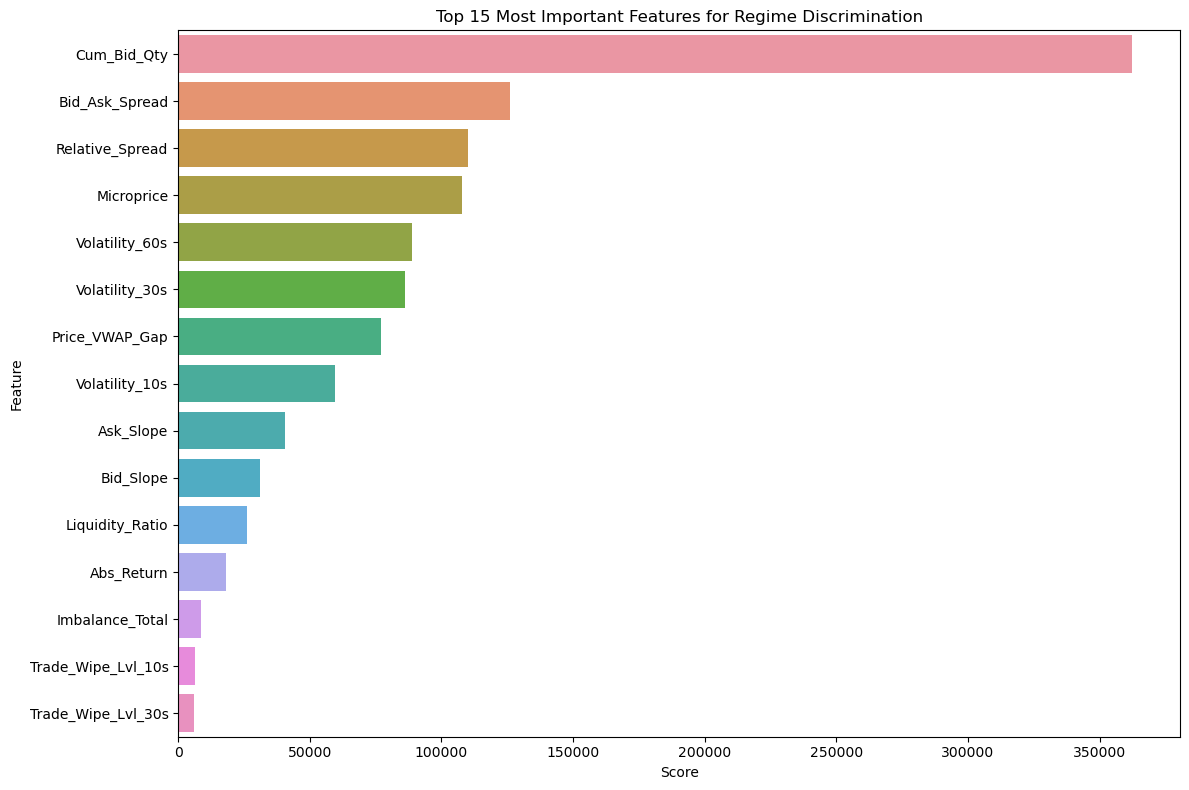

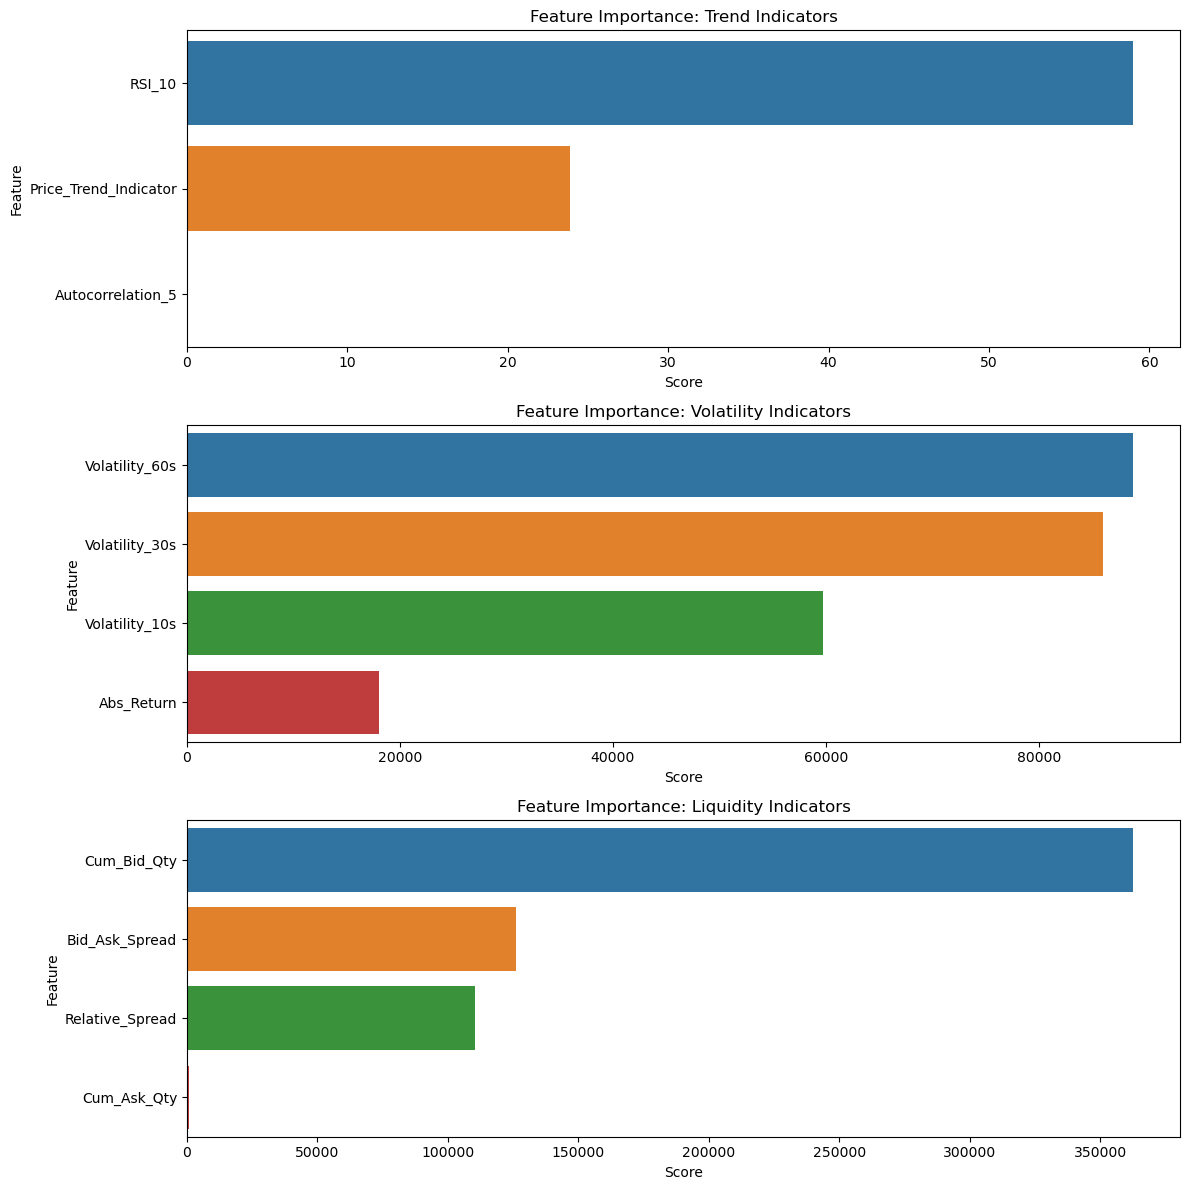

In [88]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features for Regime Discrimination')
plt.tight_layout()
plt.show()

# Analyze feature importance by category
trend_features = ['Autocorrelation_5', 'Price_Trend_Indicator', 'RSI_10']
volatility_features = ['Volatility_10s', 'Volatility_30s', 'Volatility_60s', 'Abs_Return']
liquidity_features = ['Bid_Ask_Spread', 'Relative_Spread', 'Cum_Bid_Qty', 'Cum_Ask_Qty', 'Cum_Bid_Qty_L5', 'Cum_Ask_Qty_L5']

feature_groups = {
    'Trend': trend_features,
    'Volatility': volatility_features,
    'Liquidity': liquidity_features
}

# Plot importance by category
fig, axs = plt.subplots(len(feature_groups), 1, figsize=(12, 4*len(feature_groups)))
for i, (group_name, features) in enumerate(feature_groups.items()):
    group_importance = feature_importance[feature_importance['Feature'].isin(features)]
    sns.barplot(x='Score', y='Feature', data=group_importance, ax=axs[i])
    axs[i].set_title(f'Feature Importance: {group_name} Indicators')

plt.tight_layout()
plt.show()



In [89]:
features_df.to_csv('market_regimes_labeled.csv', index=False)
print("\n Labeled data saved to 'market_regimes_labeled.csv'")


 Labeled data saved to 'market_regimes_labeled.csv'


In [90]:
# Generate summary statistics per regime
regime_summary = features_df.groupby('Regime_Name').agg({
    'Volatility_30s': ['mean', 'std'],
    'Bid_Ask_Spread': ['mean', 'std'],
    'Imbalance_Total': ['mean', 'std'],
    'Autocorrelation_5': ['mean', 'std'],
    'RSI_10': ['mean', 'std'],
    'Cum_Bid_Qty': ['mean', 'std'],
    'Cum_Ask_Qty': ['mean', 'std'],
    'Cumulative_Volume_30s': ['mean', 'std']
})

In [91]:
print("\n Detailed Regime Summary Statistics:")
print(regime_summary)


 Detailed Regime Summary Statistics:
                                     Volatility_30s           Bid_Ask_Spread  \
                                               mean       std           mean   
Regime_Name                                                                    
Mean-Reverting & Illiquid & Stable         0.000071  0.000026       0.084565   
Mean-Reverting & Illiquid & Volatile       0.000148  0.000059       0.102246   
Trending & Liquid & Stable                 0.000063  0.000025       0.051581   
Trending & Liquid & Volatile               0.000081  0.000050       0.088168   

                                               Imbalance_Total            \
                                           std            mean       std   
Regime_Name                                                                
Mean-Reverting & Illiquid & Stable    0.017993        0.002483  0.267038   
Mean-Reverting & Illiquid & Volatile  0.026510       -0.026072  0.270761   
Trending & Liquid & S

In [92]:
# Save regime summary
regime_summary.to_csv('regime_summary_statistics.csv')
print(" Regime summary statistics saved to 'regime_summary_statistics.csv'")

 Regime summary statistics saved to 'regime_summary_statistics.csv'
